# **Frag.extract - Model Training**
A Heidelberg University Beginner Practical

These are all the typical Data Science/Deep Learning libraries needed for training.
At the bottom we disable some specific warnings which Keras would produce by default.

In [0]:
import pandas as pd
import numpy as np
import re
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import warnings
warnings.simplefilter(action='ignore')
#using GPU to accelerate training
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)



The following cell is google.colab specific and can be ignored in other contexts.


In [43]:
from google.colab import files

uploaded = files.upload()

# Preprocessing

In [0]:
# data loading --> This might differ from system so system
mined = pd.read_json("conala-mined.jsonl", lines=True)
mined = mined

We plot an overview over our data. We definietly see that it is heavy on the low percentage side.

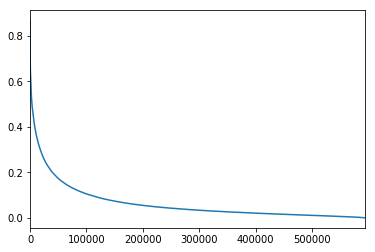

In [45]:
# Since our data is very heavy on the low side (below 20%) we shift the weights towards this spectrum, to get more nuanced results
from matplotlib import pyplot as plt
#mined['prob'] = mined['prob'].apply(lambda x: np.log(x))
#mined['prob'] = mined['prob'] + 10
#mined['prob'] = mined['prob'].apply(lambda x: x/10)
mined['prob'].plot()

# train test split
X = mined[['intent', 'snippet']]
y = mined['prob'].as_matrix()

What follows is typical NLP preprocessing. We lower our texts and remove unnecessary values.

In [0]:
# data cleanup to save memory
# usually you would want to clean up special characters like "'" or ";" but since we are dealing with code here this would be a bad idea
X['intent'] = X['intent'].apply(lambda x: x.lower())
X['intent'] = X['intent'].apply(lambda x: re.sub(pattern='[^a-z0-9]', string=x, repl=' '))

In [0]:
# concatenate snippet and intent
# the network is powerful enough and gets enough data
# to learn that our border word marks a border
X['intent'] = X['intent'] + ' UNIQUE_BORDER_SYMBOL ' + X['snippet']

In [0]:
X = X['intent']

In [0]:
X = X.astype(str)


1.   MAX_NB_WORDS -> How many words will our network "know?"

2.   MAX_SEQUENCE_LENGTH -> How long will sentences be?

3. EMBEDDING_DIM -> How complex will our data be when fed into the network?



In [0]:
# we tokenize the text and pad the tokens
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH  = 30
EMBEDDING_DIM = 450
# keras Tokenizer class which: Creates a dictionary based on the given texts
# based on word frequency where every words gets it's own unique integer
# this dictionary (tokenizer.word_index) will be exported for predictions made
# later
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(X.values)
X = tokenizer.texts_to_sequences(X.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

We save our tokenizer as JSON to late reuse it in JavaScript.


In [51]:
# let's export the word_index
to_export = tokenizer.word_index
dirty_list = []
# this marks every entry in our index which will not be used
for word, index in to_export.items():
  if index > MAX_NB_WORDS:
    dirty_list.append(word)
# this deletes every marked entry
for mark in dirty_list:
  del to_export[mark]
print(to_export)
# write dictionary to json
import json
with open('vocab.json', 'w') as json_file:
  json.dump(to_export, json_file)

{'unique': 1, 'symbol': 2, 'border': 3, 'in': 4, 'a': 5, 'python': 6, 'to': 7, "'": 8, 'how': 9, '1': 10, '0': 11, 'for': 12, 'of': 13, 'with': 14, 'i': 15, 'from': 16, 'x': 17, 'list': 18, 'self': 19, '2': 20, 'the': 21, 'def': 22, 'print': 23, 'pass': 24, 'import': 25, 'if': 26, 'return': 27, 'data': 28, 's': 29, 'np': 30, 'and': 31, 'file': 32, '3': 33, 'get': 34, 'using': 35, 'string': 36, 'array': 37, 'is': 38, 'name': 39, 'df': 40, 'numpy': 41, 'as': 42, 'b': 43, 'class': 44, 'django': 45, 'y': 46, 'value': 47, 'set': 48, '5': 49, 'do': 50, 'n': 51, 'f': 52, '4': 53, 'pandas': 54, 'key': 55, 'c': 56, 'on': 57, 'an': 58, 'can': 59, 'd': 60, 'values': 61, 'range': 62, 'line': 63, 'text': 64, 'true': 65, 'all': 66, 'path': 67, 'index': 68, 'plt': 69, 'function': 70, 'add': 71, 'matplotlib': 72, 'len': 73, 'open': 74, 'request': 75, 'find': 76, 'time': 77, '10': 78, 'os': 79, 'none': 80, 'dataframe': 81, 'datetime': 82, 'way': 83, 'object': 84, 'dict': 85, 'by': 86, 'into': 87, 'rand

# Training

Here our LSTM is built. We chose a 2-layer LSTM to emulate Encoder-Decoder networks like
Transformer which are very populare in NLP tasks today. It takes in a sentence which consists of
following structure: INTENT - stop - CODE 
which got tokenized and outputs a probabilty of INTENT and CODE belonging together

In [0]:
# this is a rather simple LSTM
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(400, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(400, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
model.add(Dense(300))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae', 'mse'])

epochs = 40
batch_size = 150

history = model.fit(X, y, epochs=epochs,verbose=1, batch_size=batch_size, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=9, min_delta=0.0001)])

Train on 475112 samples, validate on 118779 samples
Epoch 1/40
 48300/475112 [==>...........................] - ETA: 10:08 - loss: 0.0495 - mean_absolute_error: 0.0495 - mean_squared_error: 0.0081

# Postprocessing

In [0]:
# we calculate the linearized test loss
from scipy import stats
xi = np.arange(0, len(history.history['val_loss']))
y = history.history['val_loss']
slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept

This graphic is visualizing the training process.

In [0]:
# we visualize the training process
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(line)
plt.title('model loss [Mean Absolute Error]')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'test loss', 'linearized test loss'], loc='upper left')
plt.savefig('loss.pdf')
plt.show()

At last we save our model.


In [0]:
# we save our model
# lstm.h5 is the version which will actually be used when exporting to tensorflowjs
from keras.models import load_model
model.save('lstm.h5')
model.save_weights('model.h5')
model_json = model.to_json()
with open('model.json', "w") as json_file:
    json_file.write(model_json)
json_file.close()